<a href="https://colab.research.google.com/github/JMawyin/ClimateFamers/blob/main/CF_Farm_SatSearch_MacD_JM_V7_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade geopandas
!pip install --upgrade rasterio
!pip install --upgrade fiona
!pip install --upgrade sat-search
!pip install --upgrade rasterstats


     |████████████████████████████████| 1.0MB 5.0MB/s 
     |████████████████████████████████| 15.3MB 333kB/s 
     |████████████████████████████████| 6.6MB 28.6MB/s 
     |████████████████████████████████| 19.1MB 399kB/s 
Requirement already up-to-date: fiona in /usr/local/lib/python3.7/dist-packages (1.8.19)
     |████████████████████████████████| 235kB 7.5MB/s 
  Created wheel for sat-search: filename=sat_search-0.3.0-cp37-none-any.whl size=9258 sha256=23ae8365bab7ddd54f125052967fe2c923540e0098cd2dded6d16b5bc534b63b
  Stored in directory: /root/.cache/pip/wheels/fa/32/d1/c2411c257e46ad7da7547b6f3851d0316aca4e750e8b784c89
  Created wheel for sat-stac: filename=sat_stac-0.4.1-cp37-none-any.whl size=15200 sha256=0061cfa8e1edffaa8b07929c0a4af9004366c86474ac95fb69fc13e913664d82
  Stored in directory: /root/.cache/pip/wheels/4f/1b/cb/9e0ea4722a4b5b97d10e90c8e4b23789d79f9e55b4c891e038
Successfully built sat-search sat-stac
ERROR: fbprophet 0.7.1 has requirement python-dateutil>=2.8.0, but 

     |████████████████████████████████| 133kB 7.4MB/s 


In [2]:
import requests
import fiona
import geopandas as gp
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pyproj
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

import rasterio
import rasterio.mask
from shapely.geometry import Point, Polygon

#Used to generate zonal statistics from the union between polygons and raster data
from satsearch import Search
from rasterstats import zonal_stats

import time

import re
#Used to read and save files from Google Drive
#from google.colab import drive
#drive.mount('/gdrive')
#drive.mount('/content/drive')

**Functions**

In [3]:


#Calculates zonal stats when knowing a polygon and a raster.
def ZonalStats_median(poly, raster):
  zs = zonal_stats(poly, raster,
            stats="count min mean max median")
  dict_ZS = zs[0]
  value = dict_ZS['mean']
  return(value)

#Takes the output from sat_search listing all images matching criterial and creates a dataframe from it.
def Search_list_to_DF(items):
  images_df = items.summary(['date', 'id', 'eo:cloud_cover'])

  images_df = re.sub(' +', ' ', images_df) 
  #====================
  data = images_df.split(':', 1)[-1] #This removes everything in the string up and including the ":". For example "Items (85):"
  #data = images_df
  #data = data.lstrip(':')
  #print(data)
  type(data)
  df = pd.DataFrame([x.split(' ') for x in data.split('\n')])
  df = df.iloc[1: , :] #Drop the first empty row from df
  df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True) #Drop the last empty column from df
  #====================
  new_header = df.iloc[0] #grab the first row for the header
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header
  return(df)

def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

#Function to import kml from a url. Does not work when it is stored in Google Drive - file extension is not .kml
def kml_to_df(kml_url):

    # make sure that geopandas is imported
  try:
    import geopandas as gpd
    import numpy as np

  except ImportError:
    print('This function relies on external libraries. Consult the documentation and install'
      'the necessary libraries.')
  gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
  #Loads kml file containing all farms 
  r = requests.get(kml_url)
  # convert the page content to bytes
  f =  fiona.BytesCollection(bytes(r.content))
  # empty GeoDataFrame
  df = gpd.GeoDataFrame()
  # iterate over layers
  for layer in fiona.listlayers(f.path):
      s = gpd.read_file(f.path, driver='KML', layer=layer)
      df = df.append(s, ignore_index=True)
  return df


In [4]:
kml_url = 'https://raw.githubusercontent.com/JMawyin/ClimateFamers/main/Climate%20Farmers%20-%20Field%20Boundaries-4.kml'#"https://raw.githubusercontent.com/JMawyin/ClimateFamers/main/Climate%20Farmers%20-%20Field%20Boundaries.kml"

df = kml_to_df(kml_url)
df= df.to_crs({'init': 'epsg:3857'}) #change the projection to a Cartesian system (EPSG:3857, unit= m)
df["area_km2"] = df['geometry'].area/ 10**6. #Adding area column in square km
farm_poly_df = df.copy()
print(farm_poly_df)
print(type(farm_poly_df))
gdf_test = farm_poly_df.iloc[[0]]
print(type(gdf_test))
print(gdf_test)


#GeoPandas read_file only reading first part of KML
#https://gis.stackexchange.com/questions/328525/geopandas-read-file-only-reading-first-part-of-kml
# Getting polygon areas using GeoPandas
# https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


                                        Name  ...  area_km2
0   Dobimar - Field Boundaries / Feldgrenzen  ...  1.915192
1                                "Dorfwiese"  ...  0.010440
2                            "Birnbaumwiese"  ...  0.002231
3                              "Kitty-Wiese"  ...  0.006931
4               Ackerpulco -field boundaries  ...  0.075870
5                                             ...  0.021326
6                                             ...  0.051792
7                                             ...  0.000777
8                                             ...  0.000968
9                                             ...  0.002989
10                                            ...  0.025011
11                                            ...  0.001001
12                                            ...  0.008198
13                                            ...  0.003169
14                                            ...  0.002863
15                                      

In [ ]:
#Type of columns in the polygon containing dataframe
farm_poly_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         17 non-null     object  
 1   Description  17 non-null     object  
 2   geometry     17 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 536.0+ bytes


**Using Sat-Search**

In [ ]:
#Reading the polygons field boundaries and extracting the parameters of a bounding box

bounds = farm_poly_df.bounds
print(bounds['minx'])
boundary = bounds.values.tolist()
print("\nThe list of all boundaries is:\n", boundary)
print("\nThe boundaries for the first item in the dataframe",df.loc[0].at["Name"], "are:", boundary[0])

0    11.530366
1     7.337082
2     7.338415
3     7.339157
4    14.278172
Name: minx, dtype: float64

The list of all boundaries is:
 [[11.5303658, 53.6976944, 11.5498064, 53.7051405], [7.337082, 50.855086, 7.338372, 50.855793], [7.338415, 50.855377, 7.338977, 50.855664], [7.339157, 50.853997, 7.340539, 50.854484], [14.278172, 52.3779956, 14.2808435, 52.3804155]]

The boundaries for the first item in the dataframe Field Boundaries / Feldgrenzen are: [11.5303658, 53.6976944, 11.5498064, 53.7051405]


The search results contains Cloud-Optimized GeoTIFFs (COGs) a better target for our search. The query below focus on getting only COG's:

**Main Search of rasters for a given window**

In [ ]:
Max_cloud_cover = 100
Date_window = "2019-01-01/2020-12-31"
searchResults = Search(bbox=boundary[1],#boundary[farmNumber], 
                datetime=Date_window, 
                collections=['sentinel-s2-l2a-cogs'], 
                url='https://earth-search.aws.element84.com/v0',
                query={'eo:cloud_cover': {'lt': Max_cloud_cover}})
print('bbox search: %s items' % searchResults.found())

bbox search: 559 items


In [ ]:
items = searchResults.items() 
print(items.summary(['date', 'id', 'eo:cloud_cover']))#

Items (559):
date                      id                        eo:cloud_cover            
2020-12-30                S2A_31UGS_20201230_0_L2A  86.34                     
2020-12-30                S2A_32ULB_20201230_0_L2A  85.44                     
2020-12-28                S2B_31UGS_20201228_0_L2A  96.4                      
2020-12-28                S2B_32ULB_20201228_0_L2A  96.15                     
2020-12-25                S2B_31UGS_20201225_0_L2A  72.25                     
2020-12-25                S2B_32ULB_20201225_0_L2A  71.76                     
2020-12-20                S2A_31UGS_20201220_0_L2A  97.17                     
2020-12-20                S2A_32ULB_20201220_0_L2A  88.84                     
2020-12-18                S2B_31UGS_20201218_0_L2A  11.12                     
2020-12-18                S2B_32ULB_20201218_0_L2A  17.56                     
2020-12-15                S2B_32ULB_20201215_0_L2A  98.91                     
2020-12-13                S2A_31UGS_202

In [ ]:
#Storing all meta data from found images in a geopandas df and displaying it.
items.save('subset.geojson')
import geopandas as gpd

gf = gpd.read_file('subset.geojson')
gf.head()

,id,datetime,platform,constellation,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,created,updated,data_coverage,geometry
0,S2A_31UGS_20201230_0_L2A,2020-12-30T10:36:53+00:00,sentinel-2a,sentinel-2,10,0,32631,31,U,GS,0,S2A_MSIL2A_20201230T103441_N0214_R108_T31UGS_2...,40.87,86.34,True,2020-12-30T18:45:31.493999+00:00,2020-12-30T18:45:31.493999+00:00,NaN,"POLYGON ((7.35761 50.38213, 6.57252 50.40893, ..."
1,S2A_32ULB_20201230_0_L2A,2020-12-30T10:36:52+00:00,sentinel-2a,sentinel-2,10,0,32632,32,U,LB,0,S2A_MSIL2A_20201230T103441_N0214_R108_T32ULB_2...,59.69,85.44,True,2020-12-30T19:48:40.769001+00:00,2020-12-30T19:48:40.769001+00:00,NaN,"POLYGON ((6.58404 50.43872, 6.98683 51.43389, ..."
2,S2B_31UGS_20201228_0_L2A,2020-12-28T10:46:49+00:00,sentinel-2b,sentinel-2,10,0,32631,31,U,GS,0,S2B_MSIL2A_20201228T104349_N0214_R008_T31UGS_2...,100.00,96.40,True,2020-12-31T22:14:03.603000+00:00,2020-12-31T22:14:03.603000+00:00,NaN,"POLYGON ((7.35761 50.38213, 5.81552 50.42974, ..."
3,S2B_32ULB_20201228_0_L2A,2020-12-28T10:46:47+00:00,sentinel-2b,sentinel-2,10,0,32632,32,U,LB,0,S2B_MSIL2A_20201228T104349_N0214_R008_T32ULB_2...,100.00,96.15,True,2020-12-31T22:25:19.700001+00:00,2020-12-31T22:25:19.700001+00:00,NaN,"POLYGON ((6.18394 50.42972, 6.12372 51.41587, ..."
4,S2B_31UGS_20201225_0_L2A,2020-12-25T10:36:50+00:00,sentinel-2b,sentinel-2,10,0,32631,31,U,GS,0,S2B_MSIL2A_20201225T103339_N0214_R108_T31UGS_2...,40.37,72.25,True,2020-12-25T15:31:45.749001+00:00,2020-12-25T15:31:45.749001+00:00,NaN,"POLYGON ((7.35761 50.38213, 6.57983 50.40871, ..."


In [ ]:
#Dates of satellite images found matching the creteria above
print(items.calendar())

                              2019                              

      January               February               March        
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
    1  2  3  4  5  6               1  2  3               1  2  3  
 7  8  9 10 11 12 13   4  5  6  7  8  9 10   4  5  6  7  8  9 10  
14 15 16 17 18 19 20  11 12 13 14 15 16 17  11 12 13 14 15 16 17  
21 22 23 24 25 26 27  18 19 20 21 22 23 24  18 19 20 21 22 23 24  
28 29 30 31           25 26 27 28           25 26 27 28 29 30 31  

       April                  May                   June        
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7         1  2  3  4  5                  1  2  
 8  9 10 11 12 13 14   6  7  8  9 10 11 12   3  4  5  6  7  8  9  
15 16 17 18 19 20 21  13 14 15 16 17 18 19  10 11 12 13 14 15 16  
22 23 24 25 26 27 28  20 21 22 23 24 25 26  17 18 19 20 21 22 23  
29 30                 27 28 29 30 31        24 25 26 27 28 29 30  

  

**Creating Dataframe From Image Search Window Parameters**

In [ ]:
#Another way to store meta data from image search and only store some of the data. 

images_df = items.summary(['date', 'datetime', 'id', 'eo:cloud_cover','proj:epsg'])

type(images_df)
images_df
images_df = re.sub(' +', ' ', images_df) #https://www.codegrepper.com/code-examples/python/regex+to+remove+multiple+spaces+python
images_df

'Items (559):\ndate datetime id eo:cloud_cover proj:epsg \n2020-12-30 2020-12-30T10:36:53Z S2A_31UGS_20201230_0_L2A 86.34 32631 \n2020-12-30 2020-12-30T10:36:52Z S2A_32ULB_20201230_0_L2A 85.44 32632 \n2020-12-28 2020-12-28T10:46:49Z S2B_31UGS_20201228_0_L2A 96.4 32631 \n2020-12-28 2020-12-28T10:46:47Z S2B_32ULB_20201228_0_L2A 96.15 32632 \n2020-12-25 2020-12-25T10:36:50Z S2B_31UGS_20201225_0_L2A 72.25 32631 \n2020-12-25 2020-12-25T10:36:49Z S2B_32ULB_20201225_0_L2A 71.76 32632 \n2020-12-20 2020-12-20T10:36:52Z S2A_31UGS_20201220_0_L2A 97.17 32631 \n2020-12-20 2020-12-20T10:36:50Z S2A_32ULB_20201220_0_L2A 88.84 32632 \n2020-12-18 2020-12-18T10:46:47Z S2B_31UGS_20201218_0_L2A 11.12 32631 \n2020-12-18 2020-12-18T10:46:45Z S2B_32ULB_20201218_0_L2A 17.56 32632 \n2020-12-15 2020-12-15T10:36:48Z S2B_32ULB_20201215_0_L2A 98.91 32632 \n2020-12-13 2020-12-13T10:46:48Z S2A_31UGS_20201213_0_L2A 47.11 32631 \n2020-12-13 2020-12-13T10:46:46Z S2A_32ULB_20201213_0_L2A 65.88 32632 \n2020-12-10 2020-12-

In [ ]:
#https://stackoverflow.com/questions/16405601/remove-characters-before-and-including-in-python-2-7
data = images_df.split(':', 1)[-1] #This removes everything in the string up and including the ":". For example "Items (85):"
#data = images_df
#data = data.lstrip(':')
#print(data)
type(data)
df = pd.DataFrame([x.split(' ') for x in data.split('\n')])
df = df.iloc[1: , :] #Drop the first empty row from df
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True) #Drop the last empty column from df
#========
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
#========
SW_df = df.copy()


In [ ]:
SW_df.head(10)
#df.dtypes
#df.iloc[2, 1]

1,date,datetime,id,eo:cloud_cover,proj:epsg
2,2020-12-30,2020-12-30T10:36:53Z,S2A_31UGS_20201230_0_L2A,86.34,32631
3,2020-12-30,2020-12-30T10:36:52Z,S2A_32ULB_20201230_0_L2A,85.44,32632
4,2020-12-28,2020-12-28T10:46:49Z,S2B_31UGS_20201228_0_L2A,96.4,32631
5,2020-12-28,2020-12-28T10:46:47Z,S2B_32ULB_20201228_0_L2A,96.15,32632
6,2020-12-25,2020-12-25T10:36:50Z,S2B_31UGS_20201225_0_L2A,72.25,32631
7,2020-12-25,2020-12-25T10:36:49Z,S2B_32ULB_20201225_0_L2A,71.76,32632
8,2020-12-20,2020-12-20T10:36:52Z,S2A_31UGS_20201220_0_L2A,97.17,32631
9,2020-12-20,2020-12-20T10:36:50Z,S2A_32ULB_20201220_0_L2A,88.84,32632
10,2020-12-18,2020-12-18T10:46:47Z,S2B_31UGS_20201218_0_L2A,11.12,32631
11,2020-12-18,2020-12-18T10:46:45Z,S2B_32ULB_20201218_0_L2A,17.56,32632


In [ ]:
#Changing the format of the columns in df to datetime for "date" and numeric for "eo:cloud_cover"
SW_df['date']= pd.to_datetime(SW_df['date'])
SW_df['datetime']= pd.to_datetime(SW_df['datetime'])
SW_df["eo:cloud_cover"] = pd.to_numeric(SW_df["eo:cloud_cover"])
SW_df["proj:epsg"] = pd.to_numeric(SW_df["proj:epsg"])
SW_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 2 to 561
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   date            559 non-null    datetime64[ns]     
 1   datetime        559 non-null    datetime64[ns, UTC]
 2   id              559 non-null    object             
 3   eo:cloud_cover  559 non-null    float64            
 4   proj:epsg       559 non-null    float64            
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(2), object(1)
memory usage: 22.0+ KB


**Plotting the Cloud Cover Value in the  Search Window** 

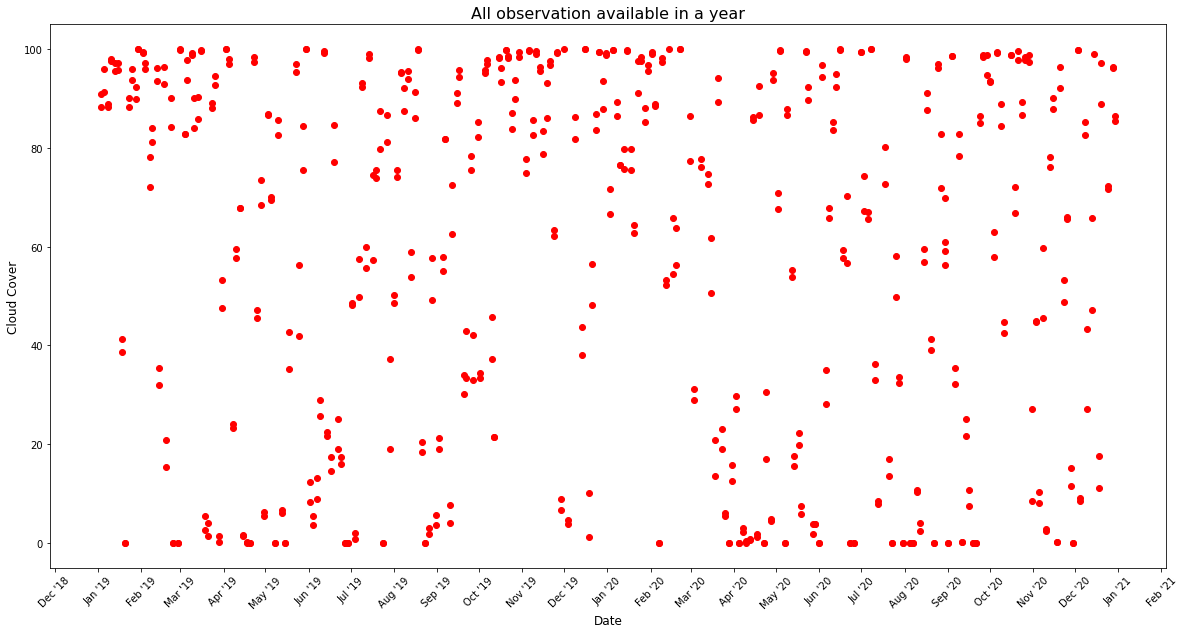

In [ ]:
from matplotlib.dates import DateFormatter, MonthLocator
fig, ax = plt.subplots() #https://stackoverflow.com/questions/28719895/when-dates-are-on-the-x-axis-how-do-i-set-the-x-axis-intervals-to-months
ax.plot_date(SW_df['date'], SW_df['eo:cloud_cover'],  'ro')
plt.title("All observation available in a year", fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cloud Cover', fontsize=12)
months = MonthLocator()
monthsFmt = DateFormatter("%b '%y")
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
plt.gcf().set_size_inches(20, 10)
plt.show()

**Histograms of Cloud Coverage Over a One Year Period**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


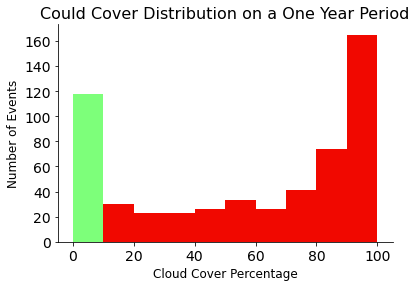

In [ ]:
N, bins, patches = plt.hist(SW_df['eo:cloud_cover'], 10)

cmap = plt.get_cmap('jet')
low = cmap(0.5)

high = cmap(0.9)


for i in range(0,1):
    patches[i].set_facecolor(low)
for i in range(1,10):
    patches[i].set_facecolor(high)

plt.title("Could Cover Distribution on a One Year Period", fontsize=16)
plt.xlabel("Cloud Cover Percentage", fontsize=12)  
plt.ylabel("Number of Events", fontsize=12)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

plt.show()

**Combined ReProjection per Farm**

In [ ]:

file_url_red = items[0].asset('red')['href']
raster_red = rasterio.open(file_url_red)
coordSystem=raster_red.crs
Farm_poly_geom = farm_poly_df.geometry
print(Farm_poly_geom)
areaOfInterest_proj = Farm_poly_geom.to_crs(coordSystem)

0    POLYGON Z ((11.53238 53.70514 0.00000, 11.5303...
1    POLYGON Z ((7.33708 50.85547 0.00000, 7.33728 ...
2    POLYGON Z ((7.33847 50.85566 0.00000, 7.33842 ...
3    POLYGON Z ((7.33916 50.85408 0.00000, 7.33933 ...
4    POLYGON Z ((14.27868 52.38042 0.00000, 14.2781...
Name: geometry, dtype: geometry


**Example showing zonal value calculation for one polygon and one raster**

In [ ]:
for i in range(len(farm_poly_df)):
  print(farm_poly_df.Name.iloc[[i]])

0    Field Boundaries / Feldgrenzen
Name: Name, dtype: object
1    "Dorfwiese"
Name: Name, dtype: object
2    "Birnbaumwiese"
Name: Name, dtype: object
3    "Kitty-Wiese"
Name: Name, dtype: object
4    Ackerpulco -field boundaries
Name: Name, dtype: object


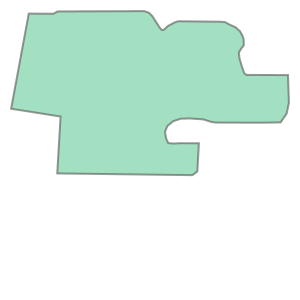

In [ ]:
loc_index = 0       #Location of farm in the kml derived dataframe
areaOfInterest_proj[loc_index]

bbox search: 16 items
2018-11-28


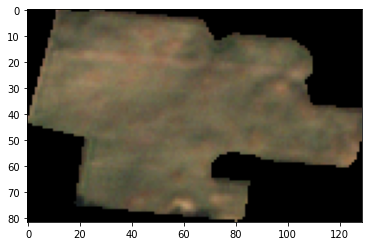

The height of the raster bounding box is 820  meters and the width is 1290 meters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


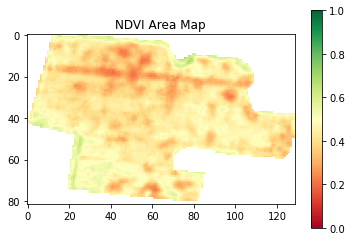

2018-11-16


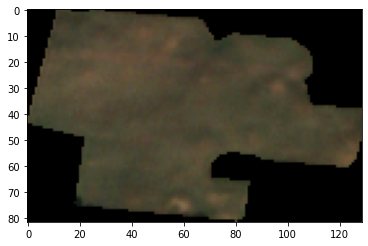

The height of the raster bounding box is 820  meters and the width is 1290 meters.


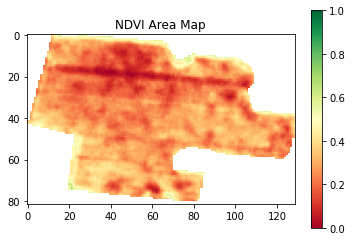

2018-11-03


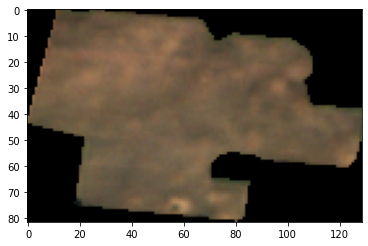

The height of the raster bounding box is 820  meters and the width is 1290 meters.


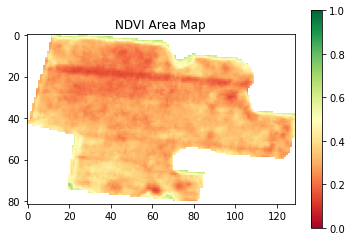

2018-10-14


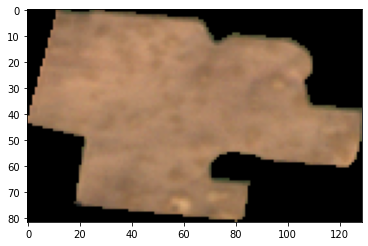

The height of the raster bounding box is 820  meters and the width is 1290 meters.


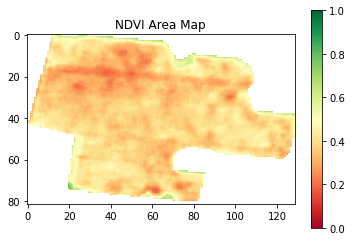

2018-10-12


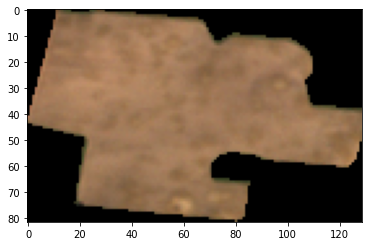

The height of the raster bounding box is 820  meters and the width is 1290 meters.


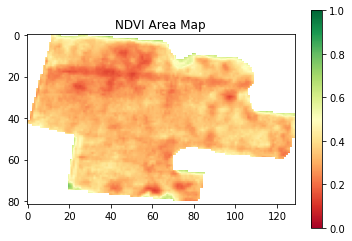

2018-09-19


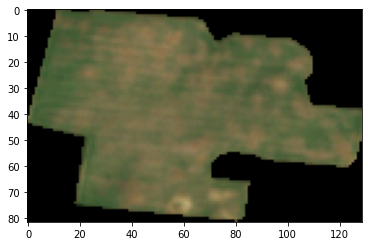

The height of the raster bounding box is 820  meters and the width is 1290 meters.


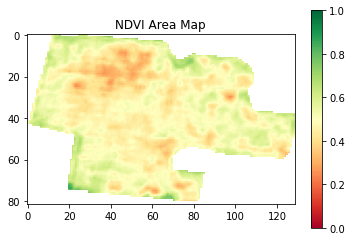

2018-08-03


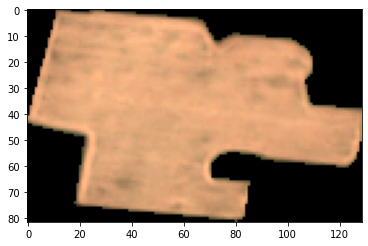

The height of the raster bounding box is 820  meters and the width is 1290 meters.


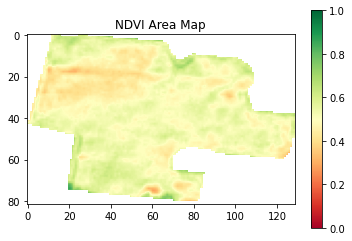

2018-07-26


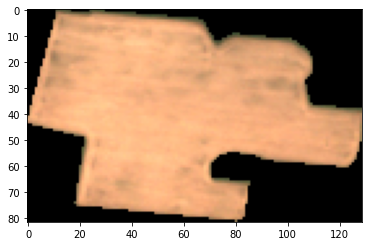

The height of the raster bounding box is 820  meters and the width is 1290 meters.


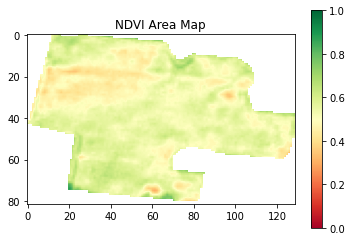

2018-07-24


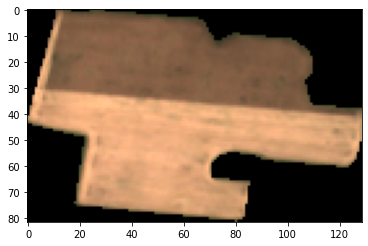

The height of the raster bounding box is 820  meters and the width is 1290 meters.


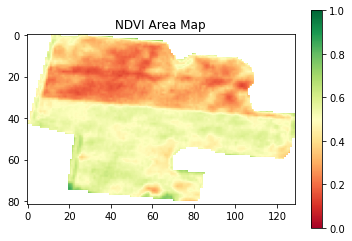

2018-07-24


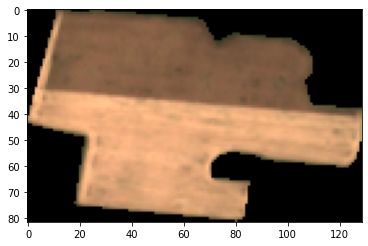

The height of the raster bounding box is 820  meters and the width is 1290 meters.


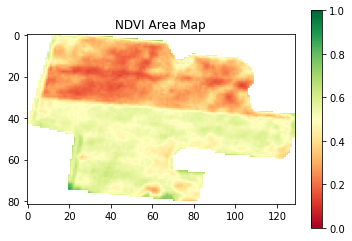

2018-07-04


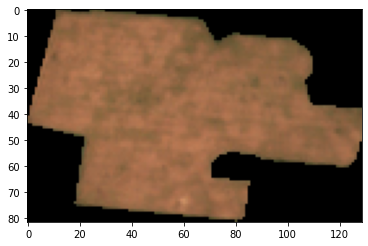

The height of the raster bounding box is 820  meters and the width is 1290 meters.


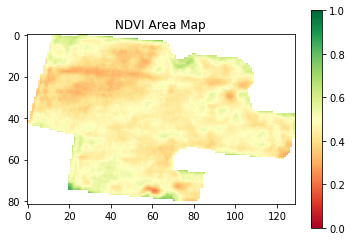

2018-06-06


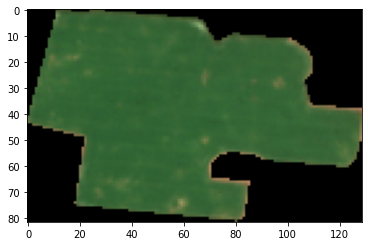

The height of the raster bounding box is 820  meters and the width is 1290 meters.


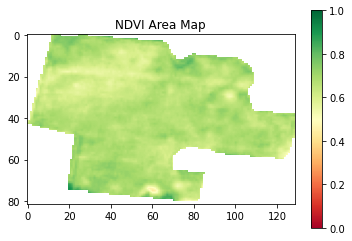

2018-05-20


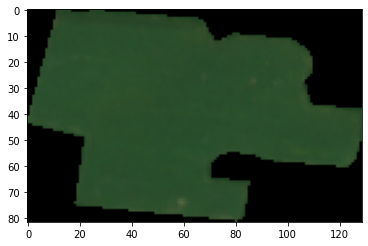

The height of the raster bounding box is 820  meters and the width is 1290 meters.


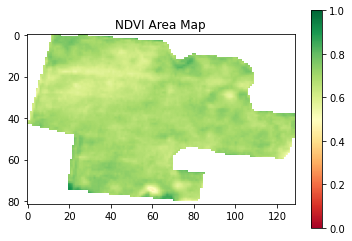

2018-05-07


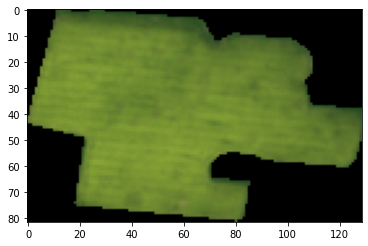

The height of the raster bounding box is 820  meters and the width is 1290 meters.


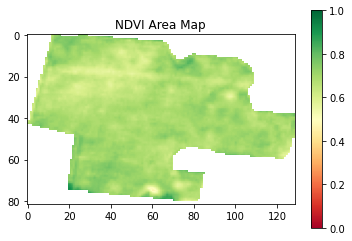

2018-05-05


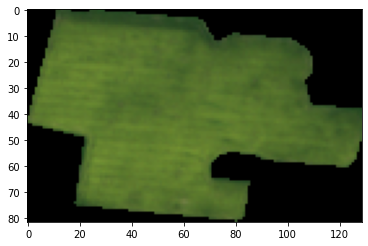

The height of the raster bounding box is 820  meters and the width is 1290 meters.


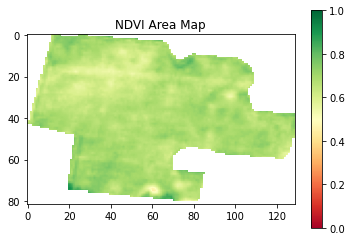

2018-04-20


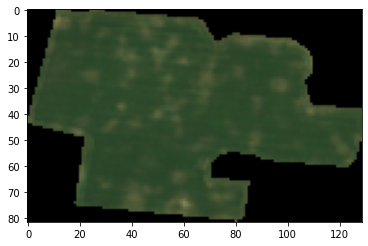

The height of the raster bounding box is 820  meters and the width is 1290 meters.


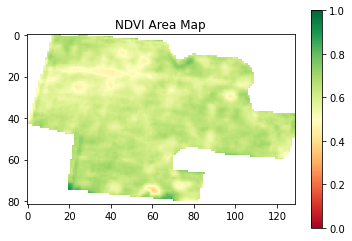

<Figure size 432x288 with 0 Axes>

In [ ]:
loc_index = 0
bounds = farm_poly_df.bounds
boundary = bounds.values.tolist()
date_window = '2018-01-01/2018-12-31'#'2020-06-01/2020-06-30'
Max_cloud_cover = 1
searchResults_test = Search(bbox=boundary[loc_index], 
                datetime=date_window, 
                collections=['sentinel-s2-l2a-cogs'], 
                url='https://earth-search.aws.element84.com/v0',
                query={'eo:cloud_cover': {'lt': Max_cloud_cover}})
print('bbox search: %s items' % searchResults_test.found())
#print('bbox search: %s items' % search.found())
items_test = searchResults_test.items() 
SW_df = Search_list_to_DF(items_test)
for win_index in range(len(SW_df)-1): 
  print(SW_df.iloc[win_index,0])
  #print(items.summary(['date', 'id', 'eo:cloud_cover']))
  file_url_red = items_test[win_index].asset('red')['href'] 
  
  file_url_nir = items_test[win_index].asset('nir')['href'] 
  file_url_tci = items_test[win_index].asset('visual')['href'] 
  #=========ReProjection_of_CRS
  file_url_red = items_test[0].asset('red')['href']
  raster_red = rasterio.open(file_url_red)
  #print(raster_red.crs)
  coordSystem=raster_red.crs
  Farm_poly_geom = farm_poly_df.geometry
  #print(Farm_poly_geom)
  areaOfInterest_proj = Farm_poly_geom.to_crs(coordSystem)

  #============================

  polygon = areaOfInterest_proj[loc_index]
  #print(areaOfInterest_proj[loc_index])
  #print(polygon)
  #=========TCI
  #print("Attempting to crop item", loc_index, "from boundary list.")
  try:
      with rasterio.open(file_url_tci) as src:
          out_image_tci, out_transform = mask(src, [polygon], all_touched=True, crop=True)
      #print("Cropped RED image successfully")
  except Exception as e:
      print("Cropping failed")
      print(repr(e))
  show(out_image_tci)
  #=========RED
  #print("Attempting to crop item", loc_index, "from boundary list.")
  try:
      with rasterio.open(file_url_red) as src:
          out_image_red, out_transform = mask(src, [polygon], all_touched=True, crop=True)
      #print("Cropped RED image successfully")
  except Exception as e:
      print("Cropping failed")
      print(repr(e))
  #show(out_image_red)
  #=========NIR
  #print("Attempting to crop item", loc_index, "from boundary list.")
  try:
      with rasterio.open(file_url_nir) as src:
          out_image_nir, out_transform = mask(src, [polygon], all_touched=True, crop=True)
      #print("Cropped NIR image successfully")
  except Exception as e:
      print("Cropping failed")
      print(repr(e))
  #show(out_image_nir)
  crop_raster_dim = out_image_nir.shape
  C_raster_h = crop_raster_dim[1]
  C_raster_w = crop_raster_dim[2]
  print("The height of the raster bounding box is", C_raster_h*10," meters and the width is",C_raster_w*10, "meters.")
  #=========
  shp_loc = areaOfInterest_proj[loc_index]
  value = ZonalStats_median(shp_loc, file_url_red)
  #print("The median RED zonal value is", value)
  value = ZonalStats_median(shp_loc, file_url_nir)
  #print("The median NIR zonal value is", value)
  #=========
  ndvi = []
  ndvi = calc_ndvi(out_image_nir,out_image_red)
  #plt.imshow(ndvi, cmap='RdYlGn')
  plt.imshow(np.squeeze(ndvi),cmap='RdYlGn', vmin=0, vmax=1)
  plt.colorbar()
  plt.title('NDVI Area Map')
  plt.show()
  plt.savefig('/content/gdrive/MyDrive/Climate_Farmers/Data/test{}.png'.format(str(win_index))) #/content/gdrive/MyDrive/Climate_Farmers/Data

In [ ]:

raster = rasterio.open(file_url_nir)
w = raster.read(window=rasterio.windows.Window(0, 0, 500, 500))
print(out_image_nir.shape)
print(w.shape)

def export_window(w, path):
    number_of_bands, height, width = w.shape

    profile = {
        "driver": "JPEG",
        "count": number_of_bands,
        "height": height,
        "width": width,
        'dtype': 'uint8',
        'transform': rasterio.Affine(1, 0, 0, 0, 1, 0),
    }
    with rasterio.open(path, 'w', **profile) as dst:
        dst.write(w)
export_window(out_image_tci, "/content/gdrive/MyDrive/Climate_Farmers/Data/export.jpg")

(1, 82, 129)
(1, 500, 500)


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:223: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


(1, 82, 129)
(82, 129)
<class 'PIL.Image.Image'>


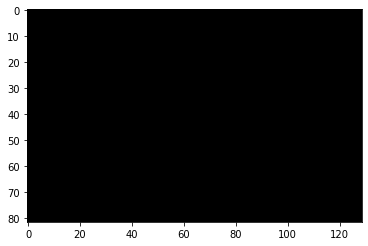

In [ ]:
#type(out_image_tci)
print(ndvi.shape)
test_image = np.squeeze(ndvi)
plt.imshow(test_image)
print(test_image.shape)
from PIL import Image
 
new_p = Image.fromarray(test_image)
#new_p = Image.fromarray(fft_p)
if new_p.mode != 'RGB':
    new_p = new_p.convert('RGB')
new_p.save("your_file.jpeg")
print(type(new_p))
im = Image.open('your_file.jpeg')
im.show()
plt.imshow(im)
#from google.colab import drive
#drive.mount('/content/gdrive')

images_dir = '/content/gdrive/MyDrive/Climate_Farmers/Data'
plt.savefig(f"{images_dir}/your_file.jpeg")

with open('/content/gdrive/MyDrive/Climate_Farmers/Data/new_p', 'w') as f: #/content/gdrive/MyDrive/Climate_Farmers/Data
  f.write('content')

In [ ]:
from PIL import Image
im = Image.fromarray(ndvi)
im.save("your_file.jpeg")

TypeError: ignored

In [ ]:
SW_df.head()

1,date,id,eo:cloud_cover
2,2019-12-31,S2B_32UPE_20191231_0_L2A,0.09
3,2019-12-13,S2A_32UPE_20191213_0_L2A,0.62
4,2019-09-22,S2B_32UPE_20190922_0_L2A,0
5,2019-07-26,S2A_32UPE_20190726_0_L2A,0
6,2019-06-29,S2A_32UPE_20190629_0_L2A,0


In [ ]:
print(raster_red.shape)
print(type(raster_red))
print(out_image.shape)
print(type(out_image))

(10980, 10980)
<class 'rasterio.io.DatasetReader'>
(1, 82, 129)
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'NDVI Area Map')

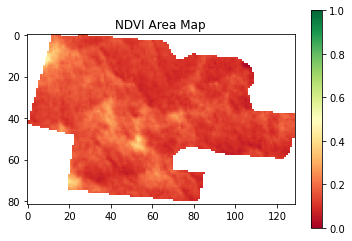

In [ ]:


ndvi = calc_ndvi(out_image_nir,out_image_red)
#plt.imshow(ndvi, cmap='RdYlGn')
plt.imshow(np.squeeze(ndvi),cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar()
plt.title('NDVI Area Map')


**Zonal Stats for all Rasters in Time Window**

**NDVI Calculations for Time Window**

**Analysing all Sites at Once**

In [ ]:
start = time.time()
bounds = farm_poly_df.bounds
boundary = bounds.values.tolist()
date_window = '2018-01-01/2018-12-31'#'2020-06-01/2020-06-30'
Max_cloud_cover = 20
#loc_index = 1
Master = []
for loc_index in range(len(farm_poly_df)):
  searchResults = Search(bbox=boundary[loc_index],
                  datetime=date_window, 
                  collections=['sentinel-s2-l2a-cogs'], 
                  url='https://earth-search.aws.element84.com/v0',
                  query={'eo:cloud_cover': {'lt': Max_cloud_cover}})
  print("In farm", farm_poly_df.iloc[loc_index,0])
  print("# observations found in farm ",farm_poly_df.iloc[loc_index,0],': %s items' % searchResults.found())
  #==========


  items = searchResults.items() 
  SW_df = Search_list_to_DF(items)
  #====================
  #SW_df = df.copy()
  #====================
  Raster_Win_Len = len(SW_df)
  print("There numer of events in the raster time window is:",Raster_Win_Len)


  #==================
  Win_ZS = []
  Win_ZS = SW_df.copy()
  Win_ZS["Farm_Name"] = farm_poly_df.iloc[loc_index,0]
  Win_ZS["Red_ZS_median"] = np.nan
  Red_Median_Cloc = Win_ZS.columns.get_loc("Red_ZS_median")
  Win_ZS["Red_crs"] = ""
  Red_CRS_Cloc = Win_ZS.columns.get_loc("Red_crs")
  Win_ZS["NIR_ZS_median"] = np.nan
  NIR_Median_Cloc = Win_ZS.columns.get_loc("NIR_ZS_median")
  Win_ZS["NIR_crs"] = ""
  NIR_CRS_Cloc = Win_ZS.columns.get_loc("Red_crs")


  for win_index in range(len(Win_ZS)-1): 
    file_url_red = items[win_index].asset('red')['href']  #Iterating over all rasters in main time window
    file_url_nir = items[win_index].asset('nir')['href']  #Iterating over all rasters in main time window
    #=========ReProjection_of_CRS
    raster_red = rasterio.open(file_url_red)
    raster_nir = rasterio.open(file_url_red)
    Win_ZS["Red_crs"] = str(raster_red.crs)
    Win_ZS["NIR_crs"] = str(raster_nir.crs)
    #print(raster_red.crs)
    coordSystem=raster_red.crs
    
    Farm_poly_geom = farm_poly_df.geometry
    #print(Farm_poly_geom)
    areaOfInterest_proj = Farm_poly_geom.to_crs(coordSystem)
    
    shp_loc = areaOfInterest_proj[loc_index]
    #Stats for Red
    value = ZonalStats_median(shp_loc, file_url_red)
    Win_ZS.iloc[win_index, Red_Median_Cloc] = value 
    value = ZonalStats_median(shp_loc, file_url_nir)
    Win_ZS.iloc[win_index, NIR_Median_Cloc] = value
    print("Processed ", win_index+1, "items of ", len(Win_ZS)-1)
  Master.append(Win_ZS)
Master = pd.concat(Master)
Master.head(30)
end = time.time()
print("Total Processing time", round(end - start,2), "seconds.")

In farm Dobimar - Field Boundaries / Feldgrenzen
# observations found in farm  Dobimar - Field Boundaries / Feldgrenzen : 39 items
There numer of events in the raster time window is: 40
Processed  1 items of  39
Processed  2 items of  39
Processed  3 items of  39
Processed  4 items of  39
Processed  5 items of  39
Processed  6 items of  39
Processed  7 items of  39
Processed  8 items of  39
Processed  9 items of  39
Processed  10 items of  39
Processed  11 items of  39
Processed  12 items of  39
Processed  13 items of  39
Processed  14 items of  39
Processed  15 items of  39
Processed  16 items of  39
Processed  17 items of  39
Processed  18 items of  39
Processed  19 items of  39
Processed  20 items of  39
Processed  21 items of  39
Processed  22 items of  39
Processed  23 items of  39
Processed  24 items of  39
Processed  25 items of  39
Processed  26 items of  39
Processed  27 items of  39
Processed  28 items of  39
Processed  29 items of  39
Processed  30 items of  39
Processed  31

**Plotting All Farms at Once**

['Dobimar - Field Boundaries / Feldgrenzen' '"Dorfwiese"'
 '"Birnbaumwiese"' '"Kitty-Wiese"' 'Ackerpulco -field boundaries' '']
There are 1219 valid entries in calculated results.


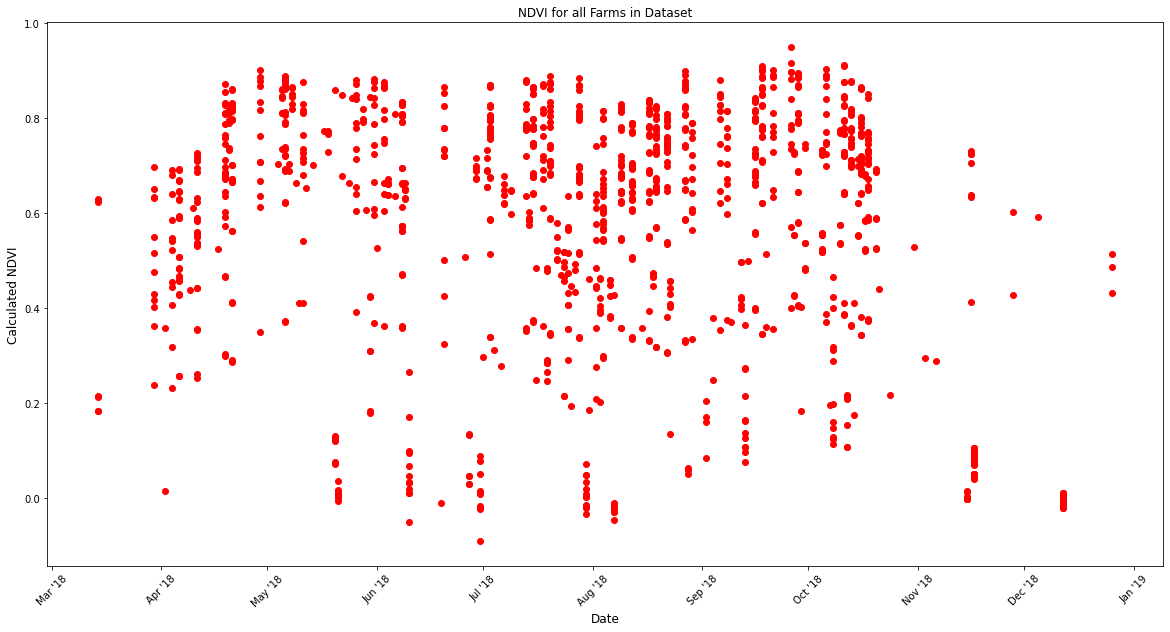

In [ ]:
#Some of the zonal stats did not produce good results. These are removed.
Win_ZS_nNA = []
Win_ZS_nNA = Master.copy()
print(Win_ZS_nNA.Farm_Name.unique())
Win_ZS_nNA['date']= pd.to_datetime(Win_ZS_nNA['date'])
Win_ZS_nNA["eo:cloud_cover"] = pd.to_numeric(Win_ZS_nNA["eo:cloud_cover"])
Win_ZS_nNA = Win_ZS_nNA.dropna()
print("There are",len(Win_ZS_nNA), "valid entries in calculated results.")
Win_ZS_nNA["NDVI"] = (Win_ZS_nNA["NIR_ZS_median"]-Win_ZS_nNA["Red_ZS_median"])/(Win_ZS_nNA["NIR_ZS_median"]+Win_ZS_nNA["Red_ZS_median"])#(nir.astype(float)-red.astype(float))/(nir+red)
Win_ZS_nNA.head(20)

from matplotlib.dates import DateFormatter, MonthLocator
fig, ax = plt.subplots() #https://stackoverflow.com/questions/28719895/when-dates-are-on-the-x-axis-how-do-i-set-the-x-axis-intervals-to-months

ax.plot_date(Win_ZS_nNA['date'], Win_ZS_nNA['NDVI'], 'ro')

plt.xticks(rotation=45)
plt.title("NDVI for all Farms in Dataset")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Calculated NDVI', fontsize=12)
months = MonthLocator()
monthsFmt = DateFormatter("%b '%y")
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
plt.gcf().set_size_inches(20, 10)
plt.show()

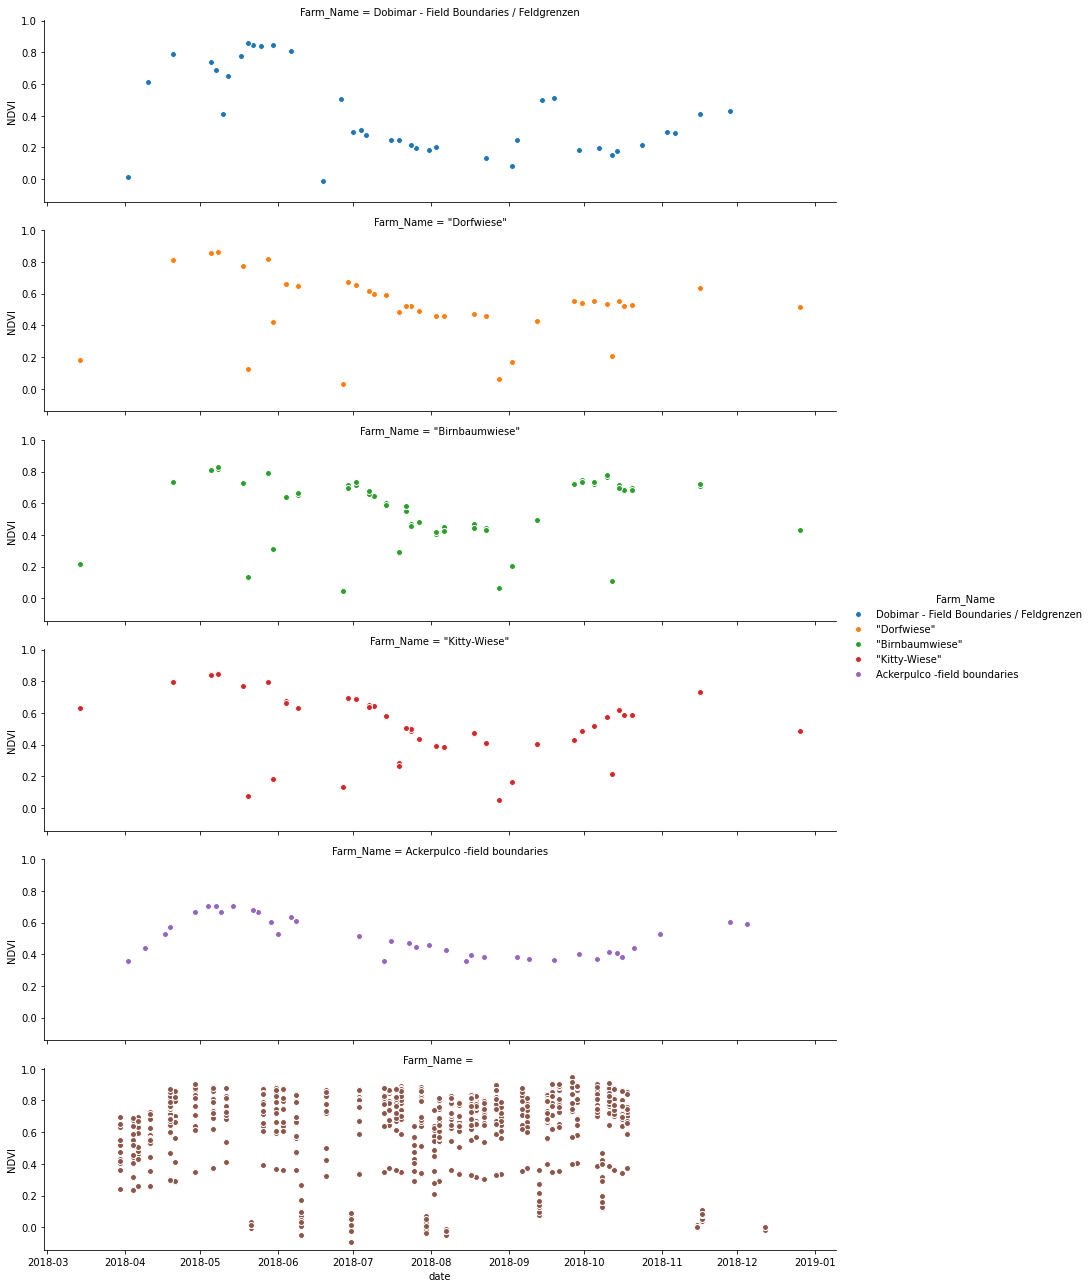

In [ ]:
# Form a facetgrid using columns with a hue
graph = seaborn.FacetGrid(Win_ZS_nNA, row ="Farm_Name",  hue ="Farm_Name", aspect=4)
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "date", "NDVI", edgecolor ="w").add_legend()
# show the object
months = MonthLocator()
monthsFmt = DateFormatter("%b '%y")
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
plt.show()

In [ ]:
Win_ZS_nNA.NIR_crs.unique()

array(['EPSG:32632', 'EPSG:32633'], dtype=object)

In [ ]:
Win_ZS_nNA.head()
Win_ZS_nNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638 entries, 2 to 79
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            638 non-null    datetime64[ns]
 1   id              638 non-null    object        
 2   eo:cloud_cover  638 non-null    float64       
 3   Farm_Name       638 non-null    object        
 4   Red_ZS_median   638 non-null    float64       
 5   Red_crs         638 non-null    object        
 6   NIR_ZS_median   638 non-null    float64       
 7   NIR_crs         638 non-null    object        
 8   NDVI            638 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 49.8+ KB


[link text](https://)**Generating Zonal Statistics**

Progress: |██████████████████████████████████████████████████| 100.0% Complete
